In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_datasets as tfds

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

2024-02-20 19:20:51.180889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 19:20:51.180985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 19:20:51.353858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Normal MNIST dataset

In [2]:
df = tfds.load('mnist_corrupted', split='train', as_supervised=True)
df = df.as_numpy_iterator()
df = list(df)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteO3PL1P/mnist_corrupted-train.tfre…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteO3PL1P/mnist_corrupted-test.tfrec…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0. Subsequent calls will reuse this data.


In [3]:
X_normal = np.array([x[0] for x in df])
y_normal = np.array([x[1] for x in df])

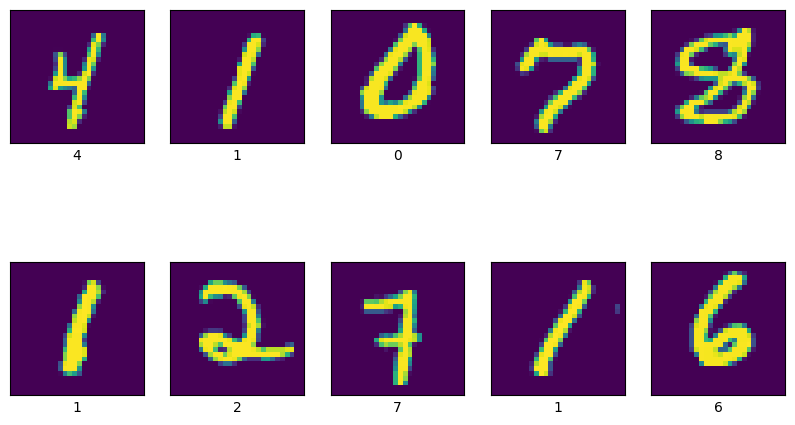

In [4]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_normal[i])
    plt.xlabel(y_normal[i])

## Corrupted MNIST dataset

In [5]:
df2 = tfds.load('mnist_corrupted/impulse_noise', split='train', as_supervised=True)
# df_2 = df_2.shuffle(1024).batch(32)
df2 = df2.as_numpy_iterator()
df2 = list(df2)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0.incompletePGSASF/mnist_corrupted-train…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0.incompletePGSASF/mnist_corrupted-test.…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0. Subsequent calls will reuse this data.


In [6]:
X_corupted = np.array([x[0] for x in df2])
y_corupted = np.array([x[1] for x in df2])

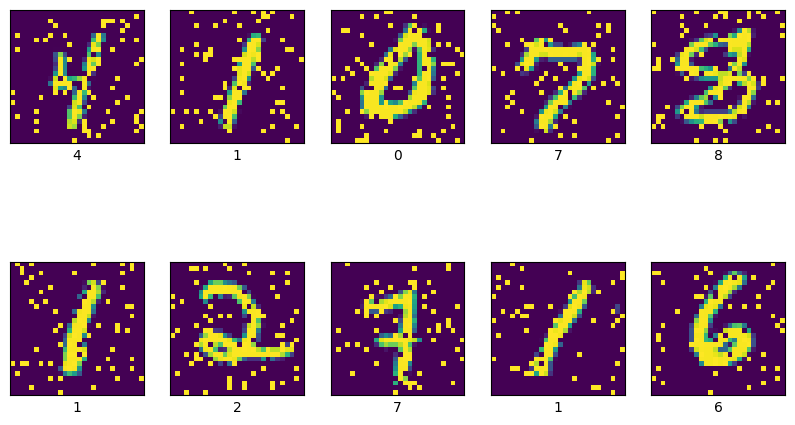

In [7]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_corupted[i])
    plt.xlabel(y_corupted[i])

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_corupted,X_normal,test_size=0.2)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((48000, 28, 28, 1),
 (48000, 28, 28, 1),
 (12000, 28, 28, 1),
 (12000, 28, 28, 1))

In [10]:
X_train = X_train.reshape(-1, 28, 28, 1)
y_train = y_train.reshape(-1, 28, 28, 1)

In [11]:
X_train.shape

(48000, 28, 28, 1)

/tmp/ipykernel_34/1753565061.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, i+1)


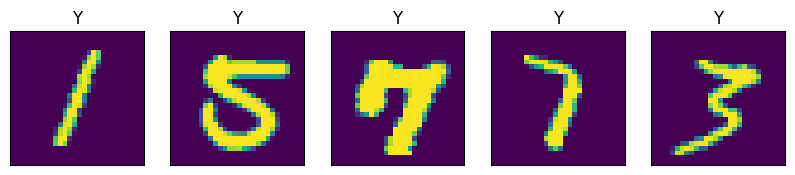

In [12]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title("X")

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_train[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title("Y")

In [13]:
model = Sequential(name='Autoencoder')
#Encoder Layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1),padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#Decoder Layers
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, kernel_size=(3, 3), activation='relu',padding='same'))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [15]:
model.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         

In [16]:
callback_es = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [17]:
model.fit(X_train,y_train,epochs=100,callbacks=[callback_es],validation_data=(X_test,y_test))

Epoch 1/100


I0000 00:00:1708457040.895195     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 14s 5ms/step - loss: 1307.8892 - accuracy: 0.7466 - val_loss: 857.0593 - val_accuracy: 0.7865
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 734.7281 - accuracy: 0.7844 - val_loss: 693.2405 - val_accuracy: 0.7879
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 623.3756 - accuracy: 0.7892 - val_loss: 598.0061 - val_accuracy: 0.7884
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 562.9559 - accuracy: 0.7915 - val_loss: 556.1713 - val_accuracy: 0.7926
Epoch 5/100
1500/1500 [==============================] - 7s 5ms/step - loss: 524.3017 - accuracy: 0.7928 - val_loss: 530.9483 - val_accuracy: 0.7952
Epoch 6/100
1500/1500 [==============================] - 7s 5ms/step - loss: 495.5026 - accuracy: 0.7939 - val_loss: 490.6073 - val_accuracy: 0.7925
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 474.6869 - accuracy: 0.7946 - val_loss:

In [18]:
encoder = Sequential()
for i in range(7):
    encoder.add(model.layers[i])

In [19]:
decoder = Sequential()
for i in range(7,13):
    decoder.add(model.layers[i])

In [20]:
encode_sample = encoder.predict(X_test)
encode_sample.shape

375/375 [==============================] - 1s 2ms/step


(12000, 4, 4, 8)

In [21]:
decoder_sample = decoder.predict(encode_sample)
decoder_sample.shape

375/375 [==============================] - 1s 1ms/step


(12000, 28, 28, 1)

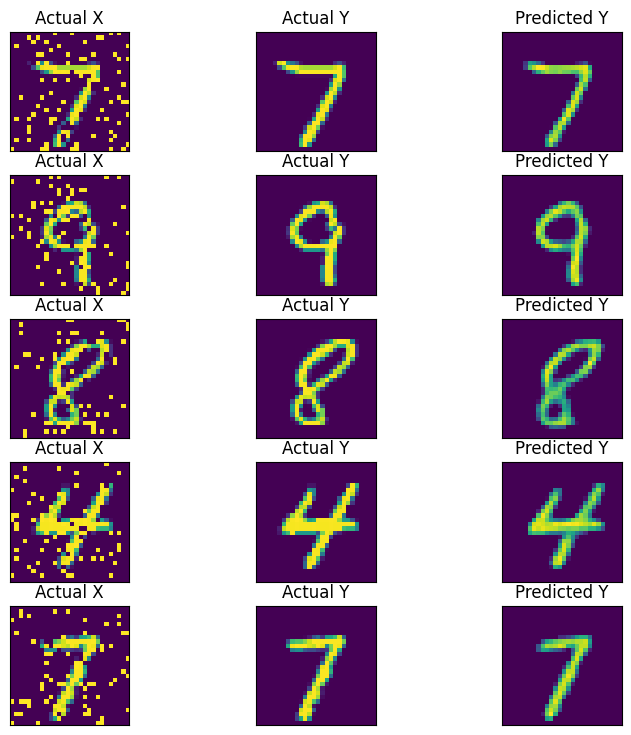

In [26]:
plt.figure(figsize=(9, 9))
samples = 5
for i in range(samples):
    indix = random.randint(0, X_test.shape[0])
    plt.subplot(samples, 3, 1+i*3)
    plt.imshow(X_test[indix].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual X")

    plt.subplot(samples, 3, 2+i*3)
    plt.imshow(y_test[indix].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual Y")

    plt.subplot(samples, 3, 3+i*3)
    plt.imshow(decoder_sample[indix].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted Y")

In [28]:
model.save("clean_mnist.h5")